<a href="https://colab.research.google.com/github/AreebaAleem/Digital_Image_Processing/blob/main/PSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt

In [ ]:
# Function for RGB to Binary Image Conversion
def rgb_to_binary(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    return binary_image

In [ ]:
# Function for Skin Detection in YCbCr color space
def detect_skin(image):
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lower_skin = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin = np.array([255, 173, 127], dtype=np.uint8)
    skin_mask = cv2.inRange(ycbcr_image, lower_skin, upper_skin)
    skin_extracted_image = cv2.bitwise_and(image, image, mask=skin_mask)
    return skin_extracted_image

In [ ]:
# Function for Edge Detection using Canny edge detector
def detect_edges(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

In [ ]:
# Function for Image Resize
def resize_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

In [ ]:
def extract_lbp_features(image):
    # Calculate Local Binary Pattern
    radius = 3
    n_points = 8 * radius
    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')

    # Calculate histogram of LBP image
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist


In [6]:
import zipfile
import os

# List of your zip files
zip_files = ['valid.zip', 'test.zip']

# Extract each zip file
for zip_file in zip_files:
    try:
        zip_path = f'/content/{zip_file}'
        if os.path.exists(zip_path):
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('/content/')
                print(f"Extracted {zip_file} successfully!")
        else:
            print(f"{zip_file} not found. Please check the file name and path.")
    except zipfile.BadZipFile:
        print(f"Failed to extract {zip_file}. The file may be corrupted or too large.")


Extracted valid.zip successfully!
Extracted test.zip successfully!


In [7]:

import zipfile
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your zip file
zip_path = '/content/drive/My Drive/train.zip'

# Extraction path
extract_to = '/content/train/'

# Create directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction Complete")




Mounted at /content/drive
Extraction Complete


NameError: name 'resized' is not defined

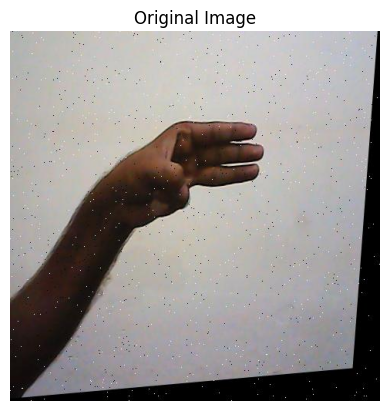

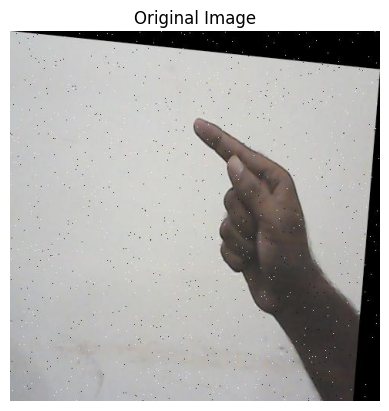

In [ ]:
# Initialize lists to store images and labels
X_train = []
y_train = []

# Define the paths to the train images and labels folders
train_images_folder = '/content/train/train/images'
train_labels_folder = '/content/train/train/labels'

# Load and display the first 2 images and labels
count = 0
for filename in os.listdir(train_images_folder):
    if filename.endswith('.jpg') and count < 2:  # Display only the first 5 images
        image_path = os.path.join(train_images_folder, filename)
        image = cv2.imread(image_path)
        if image is not None:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')
            plt.show()

            X_train.append(image)

            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_path = os.path.join(train_labels_folder, label_filename)
            with open(label_path, 'r') as label_file:
                label = label_file.read().strip()
                y_train.append(label)

            count += 1

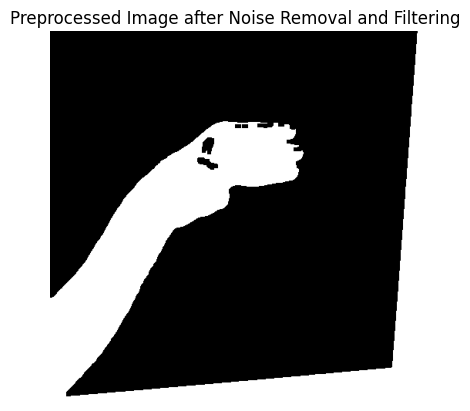

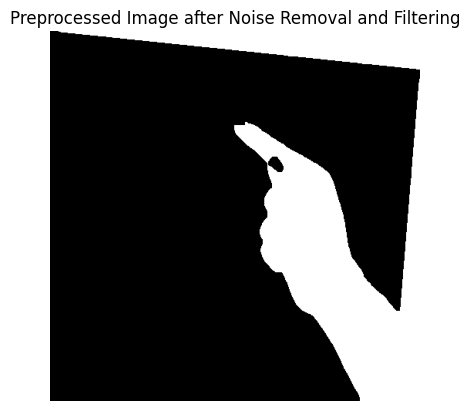

In [ ]:
# Preprocess and display only 2 images after noise removal and filtering
count = 0
for image in X_train:
    if count < 2:  # Display only the first 2 preprocessed images
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

        # Apply thresholding to create a binary image
        _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Morphological operations (e.g., erosion and dilation) to clean up the image
        kernel = np.ones((5, 5), np.uint8)
        cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

        plt.imshow(cleaned_image, cmap='gray')
        plt.title('Preprocessed Image after Noise Removal and Filtering')
        plt.axis('off')
        plt.show()

        preprocessed_images_train.append(cleaned_image)
        count += 1


In [ ]:
# Placeholder for preprocessing each image in X_train
preprocessed_images_train = []
for image in X_train:
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Apply thresholding to create a binary image
    _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations (e.g., erosion and dilation) to clean up the image
    kernel = np.ones((5, 5), np.uint8)
    cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Append the preprocessed image to the list
    preprocessed_images_train.append(cleaned_image)

In [ ]:
X_train_features = []
for image in preprocessed_images_train:
    lbp_features = extract_lbp_features(image)
    X_train_features.append(lbp_features)


In [ ]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42)

In [ ]:
# Classification
# Using Support Vector Machine (SVM) classifier as an example
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear')

In [ ]:
# Evaluation
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



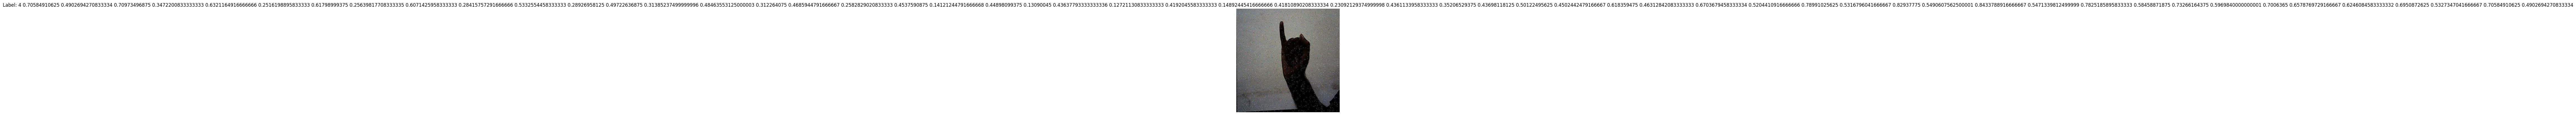

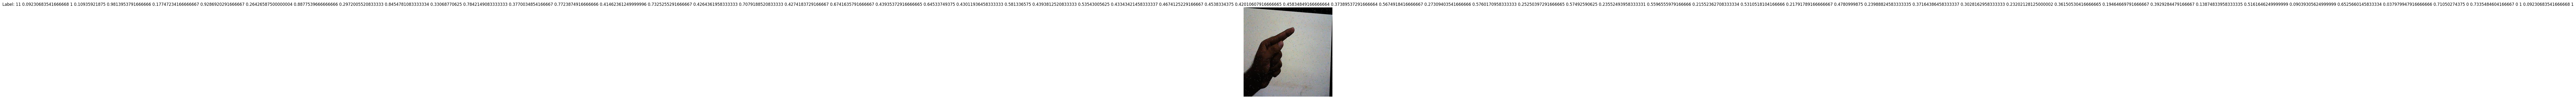

In [ ]:
# Initialize lists to store labeled images
labeled_images = []

# Loop through the images and labels folders and load labeled images
for filename in os.listdir(train_labels_folder):
    if filename.endswith('.txt'):
        label_path = os.path.join(train_labels_folder, filename)
        with open(label_path, 'r') as label_file:
            label = label_file.read().strip()
            labeled_images.append((filename, label))

# Display the labeled images
for filename, label in labeled_images[:2]:  # Display only the first 2 labeled images
    image_filename = os.path.splitext(filename)[0] + '.jpg'
    image_path = os.path.join(train_images_folder, image_filename)
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()


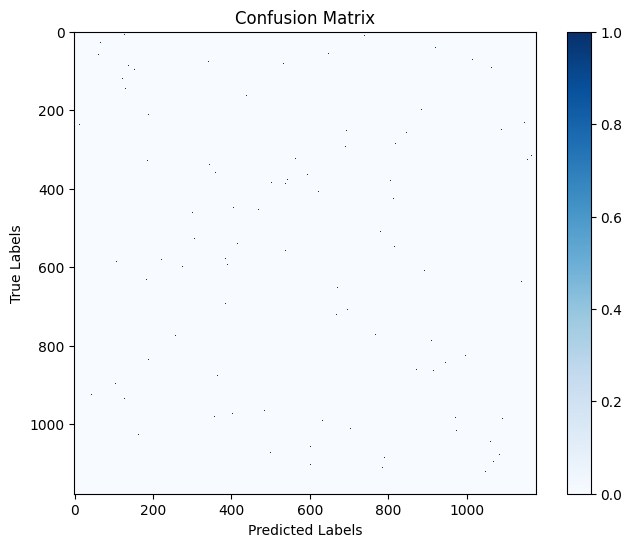

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()